In [1]:
from typing import Tuple
from random import randrange

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import easygems.healpix as egh
import healpy
import intake
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import seaborn as sb
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/share/proj failed
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['EU']
model_run = cat["icon_d3hp003"]

data = model_run(time="P1D", zoom=8).to_dask().sel(time=slice('2020-01','2020-02'))
random_timestamps = sorted(np.random.choice(data.time.values, size=24, replace=False))

projection = ccrs.PlateCarree()

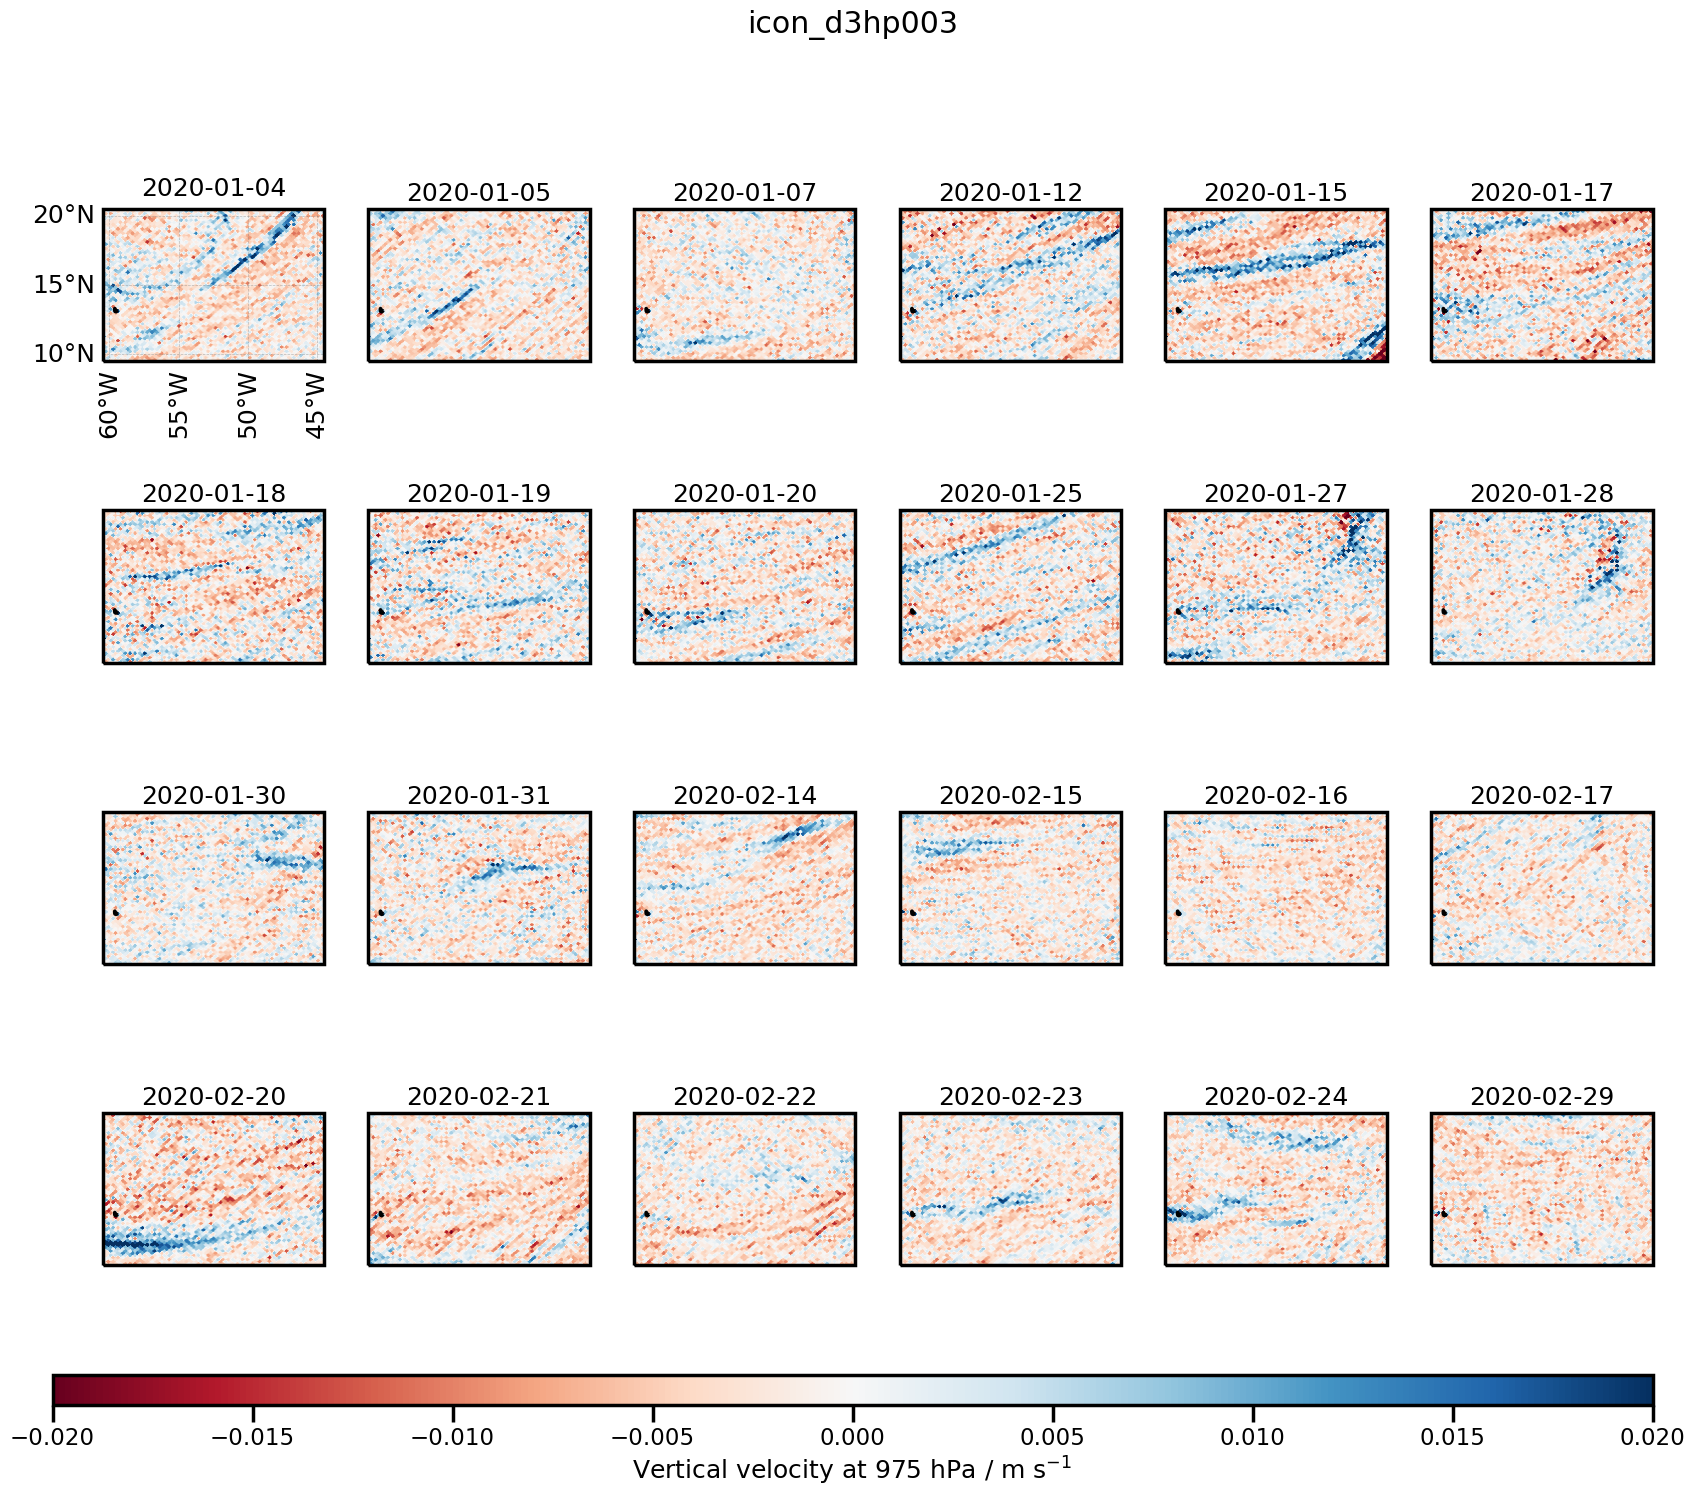

In [3]:
sb.set_context('poster',font_scale=0.75)
fig, axes = plt.subplots(4, 6, figsize=(20, 15), subplot_kw={'projection': projection },sharex=True,sharey=True)

axes = axes.flatten()
plt.suptitle('icon_d3hp003')

for i, timestamp in enumerate(random_timestamps):
    ax = axes[i]
    ax.set_extent([-60.5, -44.5, 9.5, 20.5], ccrs.PlateCarree())

    im = egh.healpix_show(data.wa.sel(time=timestamp).isel(pressure=-2), ax=ax, cmap='RdBu',vmin=-.02,vmax=.02)
    ax.set_title(str(timestamp).split('T00')[0])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.coastlines()

    if i == 0:
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True

        gl.xlocator = mticker.FixedLocator(np.arange(-60, -44, 5))
        gl.ylocator = mticker.FixedLocator(np.arange(10, 22, 5))

        gl.xlabel_style = {'rotation': 90, 'verticalalignment': 'center'}
    else:
        ax.set_xticks([], crs=ccrs.PlateCarree())
        ax.set_yticks([], crs=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Vertical velocity at 975 hPa / m s$^{-1}$')
plt.savefig('wa_at_975_hPa_icon_eurec4a.png',dpi=300,bbox_inches='tight')


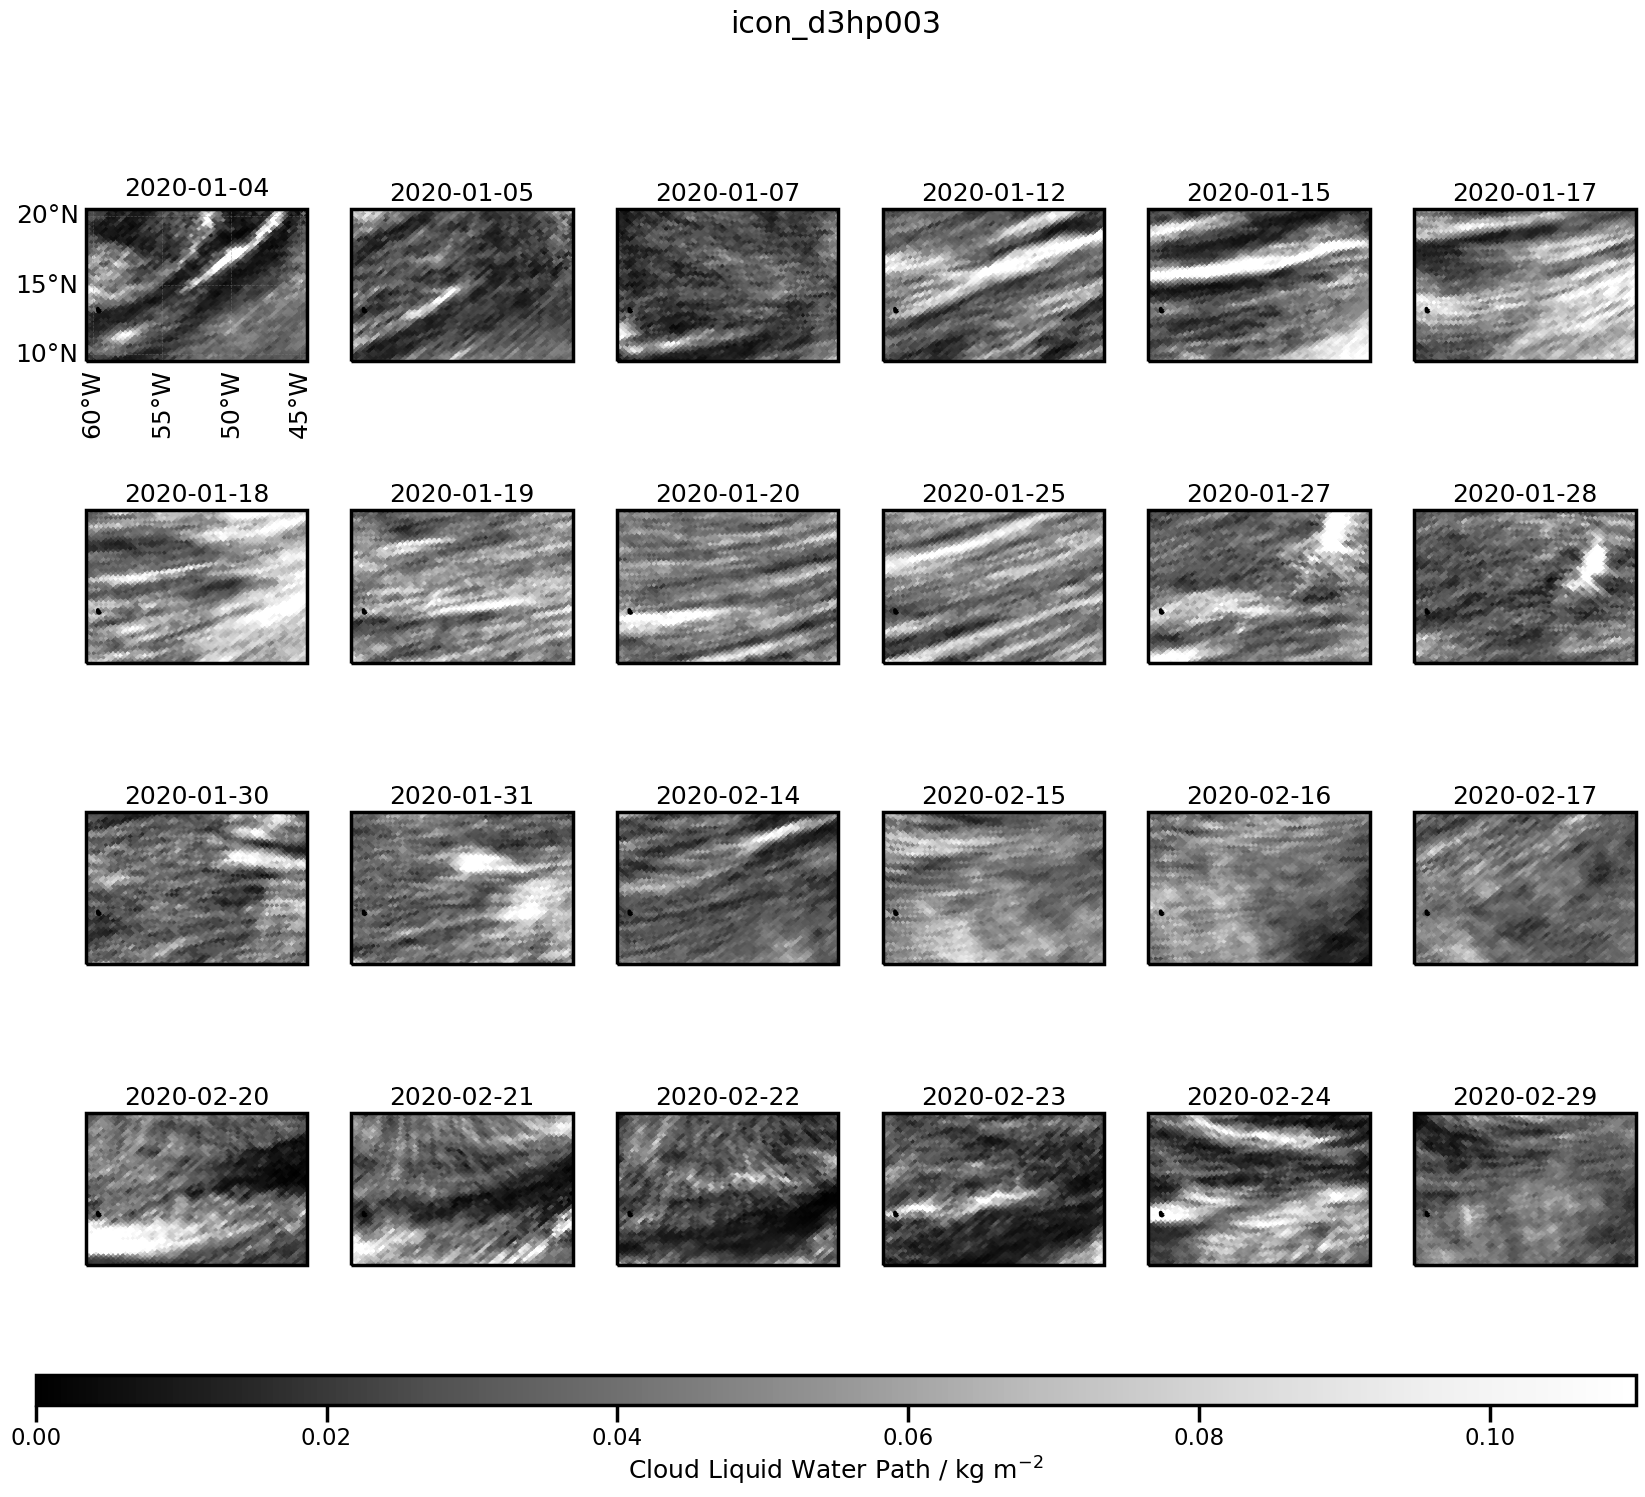

In [4]:
fig, axes = plt.subplots(4, 6, figsize=(20, 15), subplot_kw={'projection': projection },sharex=True,sharey=True)

axes = axes.flatten()
plt.suptitle('icon_d3hp003')

for i, timestamp in enumerate(random_timestamps):
    ax = axes[i]
    ax.set_extent([-60.5, -44.5, 9.5, 20.5], ccrs.PlateCarree())

    im = egh.healpix_show(data.clwvi.sel(time=timestamp), ax=ax, cmap='Greys_r',vmin=0,vmax=.11)
    ax.set_title(str(timestamp).split('T00')[0])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.coastlines()

    if i == 0:
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True

        gl.xlocator = mticker.FixedLocator(np.arange(-60, -44, 5))
        gl.ylocator = mticker.FixedLocator(np.arange(10, 22, 5))

        
        gl.xlabel_style = {'rotation': 90, 'verticalalignment': 'center'}
    else:
        
        ax.set_xticks([], crs=ccrs.PlateCarree())
        ax.set_yticks([], crs=ccrs.PlateCarree())
        
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Cloud Liquid Water Path / kg m$^{-2}$')
plt.savefig('clwvi_icon_eurec4a.png',dpi=300,bbox_inches='tight')

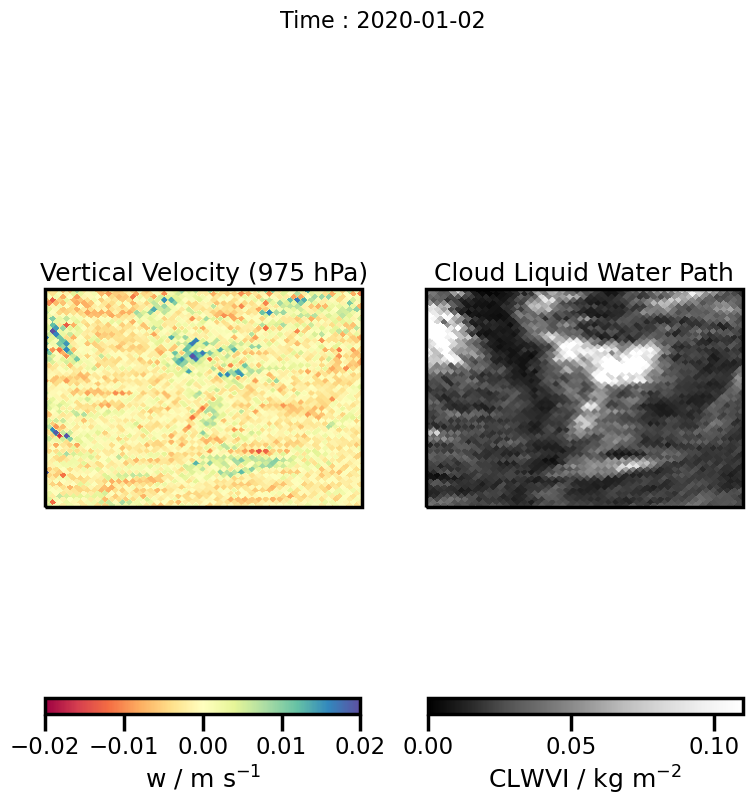

In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
import numpy as np

wa = data.wa.isel(pressure=-2) 
clwvi = data.clwvi  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,8), subplot_kw={'projection': projection})

ax1.set_extent([-60.5, -44.5, 9.5, 20.5], crs=ccrs.PlateCarree())
ax2.set_extent([-60.5, -44.5, 9.5, 20.5], crs=ccrs.PlateCarree())
wa_plot = egh.healpix_show(wa.isel(time=0), ax=ax1, cmap='Spectral',vmin=-0.02,vmax=0.02)
clwvi_plot = egh.healpix_show(clwvi.isel(time=0), ax=ax2, cmap='Greys_r',vmin=0,vmax=0.11)

ax1.set_title('Vertical Velocity (975 hPa)')
ax2.set_title('Cloud Liquid Water Path')

cbar_ax1 = fig.add_axes([0.125, 0.1, 0.35, 0.02])
fig.colorbar(wa_plot, cax=cbar_ax1, orientation='horizontal', label='w / m s$^{-1}$')
cbar_ax2 = fig.add_axes([0.55, 0.1, 0.35, 0.02])
fig.colorbar(clwvi_plot, cax=cbar_ax2, orientation='horizontal', label='CLWVI / kg m$^{-2}$')

plt.suptitle(f"Time : {str(wa.isel(time=0).time.values).split('T0')[0]}", fontsize=16)

def update(i):
    ax1.clear()
    ax2.clear()
    
    ax1.set_extent([-60.5, -44.5, 9.5, 20.5], crs=ccrs.PlateCarree())
    ax2.set_extent([-60.5, -44.5, 9.5, 20.5], crs=ccrs.PlateCarree())
    egh.healpix_show(wa.isel(time=i), ax=ax1, cmap='Spectral',vmin=-0.02,vmax=0.02)
    egh.healpix_show(clwvi.isel(time=i), ax=ax2, cmap='Greys_r',vmin=0,vmax=0.11)
    
    ax1.set_title('Vertical Velocity (975 hPa)')
    ax2.set_title('Cloud Liquid Water Path')

    plt.suptitle(f"Time : {str(wa.isel(time=i).time.values).split('T0')[0]}", fontsize=16)

ani = FuncAnimation(fig, update, frames=len(wa.time), interval=200)
ani.save('icon_animation_eurec4a.gif', writer='pillow', fps=5)

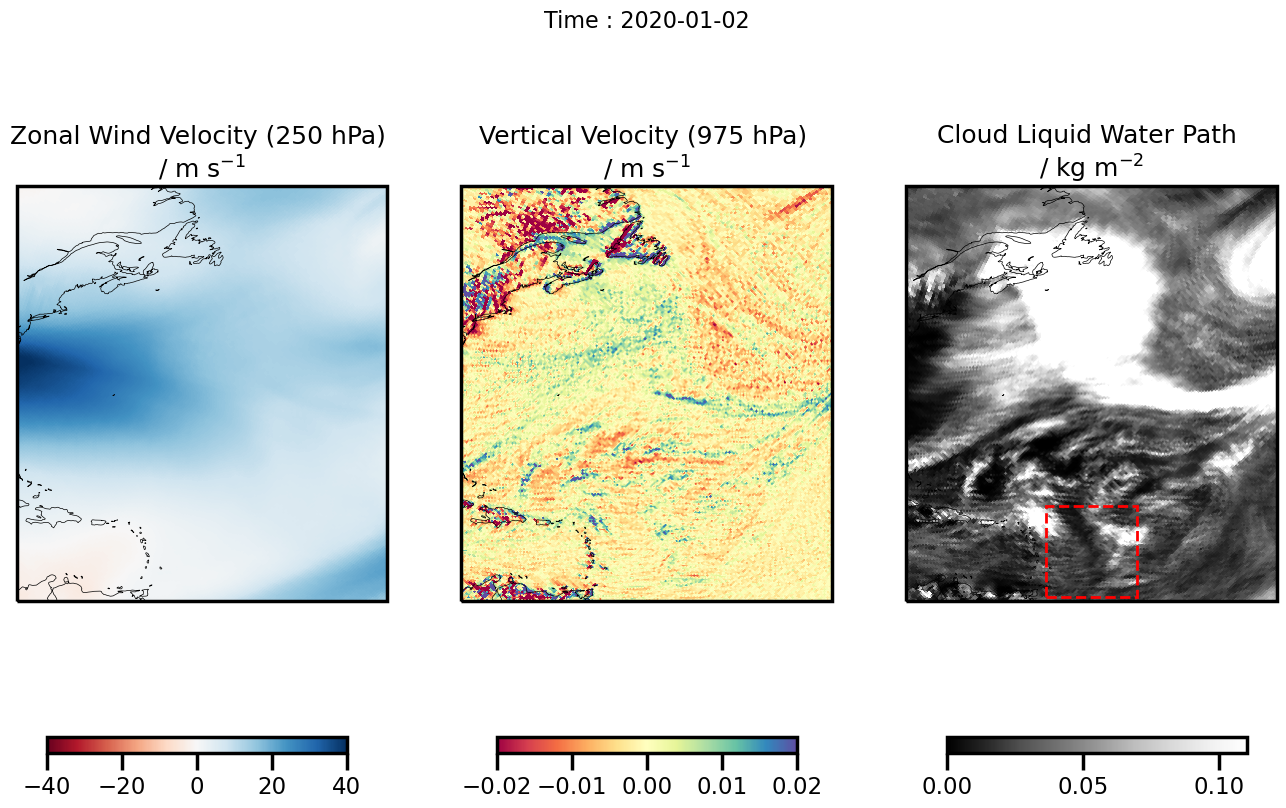

In [6]:
ua = data.ua.sel(pressure=25000)
wa = data.wa.isel(pressure=-2) 
clwvi = data.clwvi  

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': projection})

extent = [-75.5, -34.5, 9.5, 55.5]
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax3.set_extent(extent, crs=ccrs.PlateCarree())

ua_plot = egh.healpix_show(ua.isel(time=0), ax=ax1, cmap='RdBu', vmin=-40, vmax=40)
wa_plot = egh.healpix_show(wa.isel(time=0), ax=ax2, cmap='Spectral', vmin=-0.02, vmax=0.02)
clwvi_plot = egh.healpix_show(clwvi.isel(time=0), ax=ax3, cmap='Greys_r', vmin=0, vmax=0.11)

ax1.set_title('Zonal wind Velocity (250 hPa)')
ax2.set_title('Vertical Velocity (975 hPa)')
ax3.set_title('Cloud Liquid Water Path')

cbar_ax1 = fig.add_axes([0.1, 0.05, 0.2, 0.02])  
fig.colorbar(ua_plot, cax=cbar_ax1, orientation='horizontal')#, label='Zonal Wind Velocity / m s$^{-1}$')
cbar_ax2 = fig.add_axes([0.4, 0.05, 0.2, 0.02])  
fig.colorbar(wa_plot, cax=cbar_ax2, orientation='horizontal')#, label='Vertical Velocity / m s$^{-1}$')
cbar_ax3 = fig.add_axes([0.7, 0.05, 0.2, 0.02])  
fig.colorbar(clwvi_plot, cax=cbar_ax3, orientation='horizontal')#, label='CLWVI / kg m$^{-2}$')

fig.subplots_adjust(left=0.08, right=0.92, top=0.85, bottom=0.15)


def update(i):
    ax1.clear()
    ax2.clear()
    ax3.clear() 
    
    ax1.set_extent(extent, crs=ccrs.PlateCarree())
    ax2.set_extent(extent, crs=ccrs.PlateCarree())
    ax3.set_extent(extent, crs=ccrs.PlateCarree())
    
    ua_plot = egh.healpix_show(ua.isel(time=i), ax=ax1, cmap='RdBu', vmin=-40, vmax=40)
    wa_plot = egh.healpix_show(wa.isel(time=i), ax=ax2, cmap='Spectral', vmin=-0.02, vmax=0.02)
    clwvi_plot = egh.healpix_show(clwvi.isel(time=i), ax=ax3, cmap='Greys_r', vmin=0, vmax=0.11)
    
    ax1.set_title('Zonal Wind Velocity (250 hPa) \n/ m s$^{-1}$')
    ax2.set_title('Vertical Velocity (975 hPa) \n/ m s$^{-1}$')
    ax3.set_title('Cloud Liquid Water Path \n/ kg m$^{-2}$')

    [m.coastlines(linewidth=0.5) for m in [ax1,ax2,ax3]]

    rect = patches.Rectangle(
        (-60, 10),  
        10,         
        10,         
        linewidth=2, edgecolor='r', facecolor='none', linestyle='--'
    )

    ax3.add_patch(rect) 
    
    plt.suptitle(f"Time : {str(wa.isel(time=i).time.values).split('T0')[0]}", fontsize=16)

ani = FuncAnimation(fig, update, frames=len(wa.time), interval=200)
ani.save('icon_animation_large-scale.gif', writer='pillow', fps=1)